En este programa se implementa en método del gradiente descendiente

En la consigna se pide $\color{orange}{\text{Minimizar}}$ el likelihood con este método, pero eso no tiene sentido, uno lo que quiere en realidad es $\color{orange}{\text{maximizarla}}$, yo haré la maximización.

In [3]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
from Misfunciones import *
import pandas
# Estilo de gráficos
plt.style.use('dark_background')
# Seed
np.random.seed(123)

In [4]:
# Cargo datos
plt.style.use('dark_background')
Datos = pandas.read_csv('blanton.csv', sep=',')
# Pongo los datos en dos variables
Mags = Datos['M']
Lum = Datos['f']
Barra_sup = np.loadtxt('Barra_sup.txt')
Barra_inf = np.loadtxt('Barra_inf.txt')

ERR = []
ij = 0
while ij<len(Barra_sup):
    ERR.append( (1/2.) * (Barra_sup[ij] - Barra_inf[ij]) )
    ij = ij + 1
# Los límites son:
rPhi = [0.46e-2, 10.46e-2]
rMe = [-25.83, -19.93]
ralpha = [-1.5, -0.9]

La función calcula cuánto vale el Likelihood para un punto, luego hace un paso (equivalente a las cadenas de Markov) y evalúa el likelihood allí. Si el likelihood $\color{orange}{\text{aumentó}}$, entonces se acepta el punto, sino no (se sigen haciendo sorteos hasta que pase)

In [5]:
def Grad_desc(Mags, Lum, ERR, Nsteps, rPhi, rMe, ralpha, Tstep=1):
     """ Devuelve las la evolución de los parámetros mediante el método del gradiente 
     descendente (o ascendente en este caso)
    
    Parameters
    ----------
    Mags : list
        Magnitudes observadas
    Lum, ERR : list, list
        Luminosidad y sus errores asociados
    Nsteps : int
        Número de pasos de las cadenas
    rPhi, rMe, ralpha : list(2x1), list(2x1), list(2x1)
        Rangos para el PRIOR, asociados a los parámetros. Ejemplo: rPhi = [0,1]
    Tstep : .float
        Una medida del tamaño de los pasos de las cadenas (por default se calibró a 1)
        
    Returns
    -------
    Cadenas : list
        Lista con los pasos y la evolución de los parámetros
        (Paso, Phi_evol, Me_evol, alpha_evol)
    """
    import numpy as np
    from IPython.display import clear_output # Para contador en pantalla
    Pasos = []
    Phi_evol = []
    Me_evol = []
    alpha_evol = []
    LK = [] # Likelihood
    
    # Punto inicial (dentro del rango de los PRIORS tal que el Likelihood no sea cero)
    LK_actual = 0 # Likelihood inicial
    while LK_actual < 1e-8:
        phi_actual = np.random.normal(loc=np.mean([rPhi[0], rPhi[1]]),
                                      scale=(rPhi[1]-rPhi[0]))
        Me_actual = np.random.normal(loc=np.mean([rMe[0], rMe[1]]),
                                     scale=(rMe[1]-rMe[0]))
        alpha_actual = np.random.normal(loc=np.mean([ralpha[0], ralpha[1]]),
                                        scale=(ralpha[1]-ralpha[0]))
        
        LK_actual = Likelihood(Mags, Lum, ERR, phi_actual, Me_actual, alpha_actual)
    Phi = phi_actual
    Me = Me_actual
    alpha = alpha_actual
    
    ij = 0
    counter = 1 # Sirve para achicar los pasos
    while ij<Nsteps:
        F = Likelihood(Mags, Lum, ERR, Phi, Me, alpha)
        # Para programar los saltos uso la proporción de pasos que encontré en las cadenas
        counter = counter + 1
        if counter>50: # Si intento 50 veces y no logro moverme --> achico el paso
            Tstep = 0.1*Tstep
        Saltos = np.random.normal(loc=0, scale=Tstep, size=3)
        
        Phi_candid = Phi + 0.001*Saltos[0]
        Me_candid = Me + 0.01*Saltos[1]
        alpha_candid = alpha + 0.005*Saltos[2]
        F_mas_delta = Likelihood(Mags, Lum, ERR, Phi_candid, Me_candid, alpha_candid)
        
        # ESTA CONDICIÓN AVECES PARECE QUE FUNCIONA Y OTRAS NO:
        if (abs(F-F_mas_delta))<1:
            clear_output(wait=True)
            print('Se ha complido la condición de convergencia en', ij, ' pasos')
            break
    
        if F_mas_delta > F: # Si el gradiente ascendió (busco maximizar la función), entonces:
            Phi = Phi_candid
            Me = Me_candid
            alpha = alpha_candid
            
            Pasos.append(ij)
            Phi_evol.append(Phi_candid)
            Me_evol.append(Me_candid)
            alpha_evol.append(alpha_candid)
            LK.append(F_mas_delta)
            # Imprime progreso en pantalla:
            clear_output(wait=True)
            print('%', round(ij*100/Nsteps))
            counter = 1 # Reinicio contador
            ij = ij + 1 
        else:
            ij = ij 
   
    return Pasos, Phi_evol, Me_evol, alpha_evol, LK

In [6]:
Pasos = []
Phi = []
Me = []
alpha = []
LK = []
ij = 0
while ij<5:
    M = Grad_desc(Mags=Mags, Lum=Lum, ERR=ERR, Nsteps=2000, rPhi=rPhi, rMe=rMe, ralpha=ralpha);
    Pasos.append(M[0])
    Phi.append(M[1])
    Me.append(M[2])
    alpha.append(M[3])
    LK.append(M[4])
    ij = ij + 1

% 100


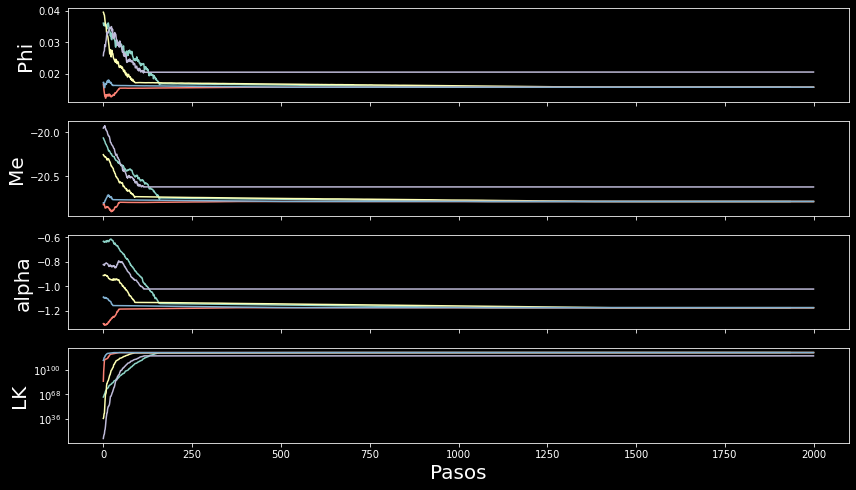

In [7]:
fig, ax = plt.subplots(4, 1, figsize = (14,8), sharex=True)

# Calulo varias veces usando en nuevo método
ij = 0
while ij<5:
    ax[0].plot(Pasos[ij], Phi[ij])
    ax[1].plot(Pasos[ij], Me[ij])
    ax[2].plot(Pasos[ij], alpha[ij])
    ax[3].plot(Pasos[ij], LK[ij])
    ij = ij + 1
    
ax[0].set_ylabel('Phi', fontsize=20)
ax[1].set_ylabel('Me', fontsize=20)
ax[2].set_ylabel('alpha', fontsize=20)
ax[3].set_ylabel('LK', fontsize=20)
ax[3].set_xlabel('Pasos', fontsize=20)
ax[3].set_yscale('log');

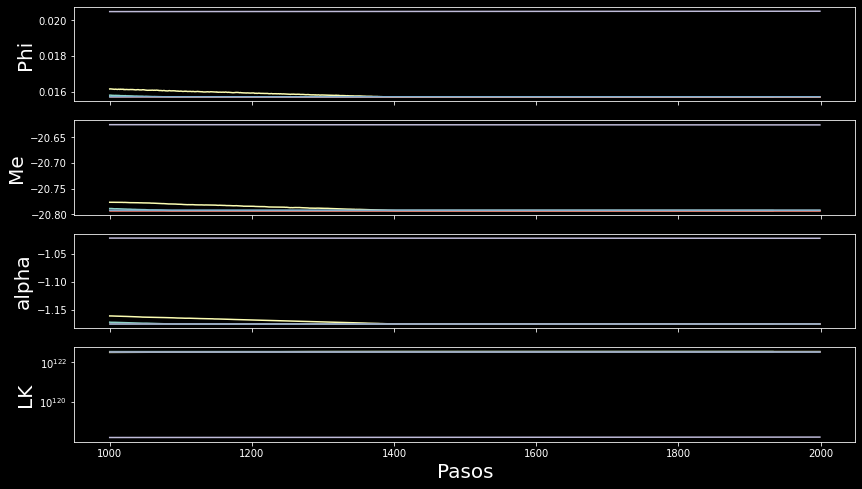

In [8]:
""" HACIENDO UN 'QUEMADO' QUEDA:"""
fig, ax = plt.subplots(4, 1, figsize = (14,8), sharex=True)

# Calulo varias veces usando en nuevo método
ij = 0
while ij<5:
    ax[0].plot(Pasos[ij][1000:], Phi[ij][1000:])
    ax[1].plot(Pasos[ij][1000:], Me[ij][1000:])
    ax[2].plot(Pasos[ij][1000:], alpha[ij][1000:])
    ax[3].plot(Pasos[ij][1000:], LK[ij][1000:])
    ij = ij + 1
    
ax[0].set_ylabel('Phi', fontsize=20)
ax[1].set_ylabel('Me', fontsize=20)
ax[2].set_ylabel('alpha', fontsize=20)
ax[3].set_ylabel('LK', fontsize=20)
ax[3].set_xlabel('Pasos', fontsize=20)
ax[3].set_yscale('log');

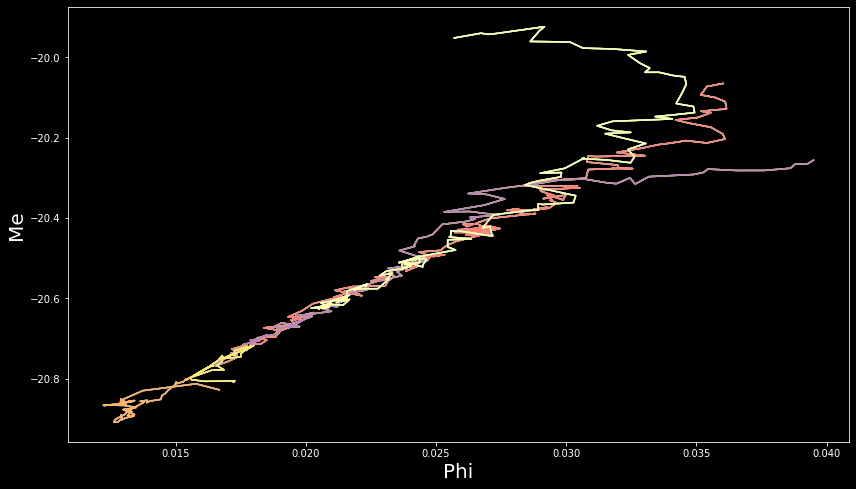

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (14,8), sharex=True)

# Calulo varias veces usando en nuevo método
ij = 0
while ij<5:
    ax.plot(Phi[ij], Me[ij])
    ax.plot(Phi[ij], Me[ij])
    ax.plot(Phi[ij], Me[ij])
    ax.plot(Phi[ij], Me[ij])
    ij = ij + 1
    
ax.set_ylabel('Me', fontsize=20)
ax.set_xlabel('Phi', fontsize=20);

No se si es por un error de programación o qué, pero hay una "cadena" que hace que los gráficos vs el paso se vean mal. Parecería que este método funciona bien, pero ésto es esperable dado que la posterior o, en realidad, el likelihood sólo tiene un máximo (eso se vió cuando se corrieron las cadenas de Markov). 

Por la forma que yo lo programé, me parece que este método es muchisimo MENOS eficiente que las caedenas de Markov, resulta que hacer sorteos hasta que se cumpla que el likelihood aumente y sólo ahí tomar válido el paso es muy ineficiente.

Por razones de no llenar de documentos de texto git, no guardaré las "cadenas" asociadas a este método en archivos

Sólo por cuestiones de tiempo no haré un análisis de intervalos de confianza. También está la posibilidad de que haya entendido mal cómo se programa el método y todo analisis sería para nada